In [4]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

# URL for 2024 MLB standard batting stats
url = "https://www.baseball-reference.com/leagues/MLB/2024-standard-batting.shtml"


options = Options()

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Load page
driver.get(url)
time.sleep(4)

table = driver.find_element(By.ID, "players_standard_batting")


header = table.find_element(By.TAG_NAME, "thead")
header_row = header.find_element(By.TAG_NAME, "tr")
headers = [th.text.strip() for th in header_row.find_elements(By.TAG_NAME, "th")][1:]  # skip empty corner


body = table.find_element(By.TAG_NAME, "tbody")
rows = body.find_elements(By.TAG_NAME, "tr")

data = []
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if cols:
        data.append([col.text.strip() for col in cols])

driver.quit()

# Build DataFrame
df = pd.DataFrame(data, columns=headers)


df.head()


,Player,Age,Team,Lg,WAR,G,PA,AB,R,H,...,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos,Awards
0,Jarren Duran*,27,BOS,AL,8.7,160,735,671,111,191,...,.373,134,330,6,6,1,3,1,*87,"AS,MVP-8"
1,Shohei Ohtani*,29,LAD,NL,9.2,159,731,636,134,197,...,.449,190,411,7,6,0,5,10,*D,"AS,MVP-1,SS"
2,Gunnar Henderson*,23,BAL,AL,9.1,159,719,630,118,177,...,.385,157,333,2,7,0,4,1,*6/D,"AS,MVP-4"
3,Marcus Semien,33,TEX,AL,4.1,159,718,650,101,154,...,.310,100,254,9,3,0,1,2,*4,AS
4,Juan Soto*,25,NYY,AL,7.9,157,713,576,128,166,...,.424,179,328,10,4,0,4,2,*9/7DH,"AS,MVP-3,SS"


In [5]:
df.to_csv(r"C:\Users\Ben Schieber\Downloads\mlb_batting_proposal.csv", header = True, index = False, encoding = 'utf-8')

In [6]:
string_cols = ['Player', 'Tm']
int_cols = ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
            'SB', 'CS', 'BB', 'SO', 'OPS+']
float_cols = ['BA', 'OBP', 'SLG', 'OPS']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # nullable int

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dtypes

Player     object
Age         Int64
Team       object
Lg         object
WAR        object
G           Int64
PA          Int64
AB          Int64
R           Int64
H           Int64
2B          Int64
3B          Int64
HR          Int64
RBI         Int64
SB          Int64
CS          Int64
BB          Int64
SO          Int64
BA        float64
OBP       float64
SLG       float64
OPS       float64
OPS+        Int64
rOBA       object
Rbat+      object
TB         object
GIDP       object
HBP        object
SH         object
SF         object
IBB        object
Pos        object
Awards     object
dtype: object

#### Merge Salary and Batting Datasets

In [7]:
salary_df = pd.read_csv("salary_data.csv", encoding='latin1')

# Filter salary data to only 2024
salary_2024 = salary_df[salary_df["Year"] == 2024].copy()
batting_df = pd.read_csv("mlb_batting_proposal.csv", encoding='utf-8')

batting_df["Player"] = batting_df["Player"].str.replace("*", "", regex=False).str.strip()
salary_2024["Name"] = salary_2024["Name"].str.strip()

# Merge on player name and team
merged_df = pd.merge(
    batting_df,
    salary_2024,
    left_on=["Player", "Team"],
    right_on=["Name", "Team"],
    how="inner"
)

merged_df.drop(columns=["Name", "Year"], inplace=True)

merged_df.to_csv("merged_mlb_2024.csv", index=False)

In [8]:
merged_df

,Player,Age,Team,Lg,WAR,G,PA,AB,R,H,...,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos,Awards,Salary
0,Jarren Duran,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,191.0,...,134.0,330.0,6.0,6.0,1.0,3.0,1.0,*87,"AS,MVP-8","$2,081,661"
1,Shohei Ohtani,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,197.0,...,190.0,411.0,7.0,6.0,0.0,5.0,10.0,*D,"AS,MVP-1,SS","$2,000,000"
2,Gunnar Henderson,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,177.0,...,157.0,333.0,2.0,7.0,0.0,4.0,1.0,*6/D,"AS,MVP-4","$2,763,378"
3,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,154.0,...,100.0,254.0,9.0,3.0,0.0,1.0,2.0,*4,AS,"$26,000,000"
4,Juan Soto,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,166.0,...,179.0,328.0,10.0,4.0,0.0,4.0,2.0,*9/7DH,"AS,MVP-3,SS","$31,000,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Austin Voth,32.0,SEA,AL,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,"$1,400,000"
357,Jacob Webb,30.0,BAL,AL,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,"$1,000,000"
358,Justin Wilson,36.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,"$1,500,000"
359,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,"$623,009"


#### Removing Players who have no Plate Appearences

In [9]:
merged_df = merged_df[merged_df["PA"].notna() & (merged_df["PA"] > 0)]

In [10]:
merged_df

,Player,Age,Team,Lg,WAR,G,PA,AB,R,H,...,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos,Awards,Salary
0,Jarren Duran,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,191.0,...,134.0,330.0,6.0,6.0,1.0,3.0,1.0,*87,"AS,MVP-8","$2,081,661"
1,Shohei Ohtani,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,197.0,...,190.0,411.0,7.0,6.0,0.0,5.0,10.0,*D,"AS,MVP-1,SS","$2,000,000"
2,Gunnar Henderson,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,177.0,...,157.0,333.0,2.0,7.0,0.0,4.0,1.0,*6/D,"AS,MVP-4","$2,763,378"
3,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,154.0,...,100.0,254.0,9.0,3.0,0.0,1.0,2.0,*4,AS,"$26,000,000"
4,Juan Soto,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,166.0,...,179.0,328.0,10.0,4.0,0.0,4.0,2.0,*9/7DH,"AS,MVP-3,SS","$31,000,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Michael Helman,28.0,MIN,AL,0.1,9.0,10.0,10.0,2.0,3.0,...,109.0,5.0,0.0,0.0,0.0,0.0,0.0,/8H759,NaN,"$51,714"
315,Liover Peguero,23.0,PIT,NL,-0.1,3.0,10.0,10.0,0.0,2.0,...,17.0,3.0,0.0,0.0,0.0,0.0,0.0,/6,NaN,"$31,824"
316,Dustin Harris,24.0,TEX,AL,0.2,2.0,7.0,6.0,1.0,2.0,...,285.0,6.0,0.0,0.0,0.0,0.0,0.0,/D,NaN,"$19,890"
317,Luis Castillo,31.0,SEA,AL,0.0,1.0,1.0,1.0,0.0,0.0,...,-118.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,"$22,750,000"


In [11]:
# Clean salary column for numeric operations
merged_df["Salary"] = merged_df["Salary"].replace('[\$,]', '', regex=True).astype(float)

# Select only the relevant columns
analysis_df = merged_df[[
    "Player", "Age", "Team", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "RBI", "Salary"
]].copy()

C:\Users\Ben Schieber\AppData\Local\Temp\ipykernel_14656\2450812731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["Salary"] = merged_df["Salary"].replace('[\$,]', '', regex=True).astype(float)


#### Choosing columns only essential to my questions

In [12]:
analysis_df

,Player,Age,Team,HR,BB,SO,BA,OBP,SLG,OPS,RBI,Salary
0,Jarren Duran,27.0,BOS,21.0,54.0,160.0,0.285,0.342,0.492,0.834,75.0,2081661.0
1,Shohei Ohtani,29.0,LAD,54.0,81.0,162.0,0.310,0.390,0.646,1.036,130.0,2000000.0
2,Gunnar Henderson,23.0,BAL,37.0,78.0,159.0,0.281,0.364,0.529,0.893,92.0,2763378.0
3,Marcus Semien,33.0,TEX,23.0,64.0,105.0,0.237,0.308,0.391,0.699,74.0,26000000.0
4,Juan Soto,25.0,NYY,41.0,129.0,119.0,0.288,0.419,0.569,0.989,109.0,31000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
314,Michael Helman,28.0,MIN,0.0,0.0,3.0,0.300,0.300,0.500,0.800,0.0,51714.0
315,Liover Peguero,23.0,PIT,0.0,0.0,3.0,0.200,0.200,0.300,0.500,2.0,31824.0
316,Dustin Harris,24.0,TEX,1.0,1.0,2.0,0.333,0.429,1.000,1.429,3.0,19890.0
317,Luis Castillo,31.0,SEA,0.0,0.0,1.0,0.000,0.000,0.000,0.000,0.0,22750000.0


#### Hypothesis Test to see if there is a significant difference between OPS for players under and over 30

In [13]:
from scipy.stats import ttest_ind
younger = analysis_df[analysis_df['Age'] < 30]['OPS']
older = analysis_df[analysis_df['Age'] >= 30]['OPS']
t_stat, p_val = ttest_ind(younger, older, nan_policy='omit')
print(t_stat, p_val)

-1.0346224152207204 0.3016339092221429


#### No statistically significant difference

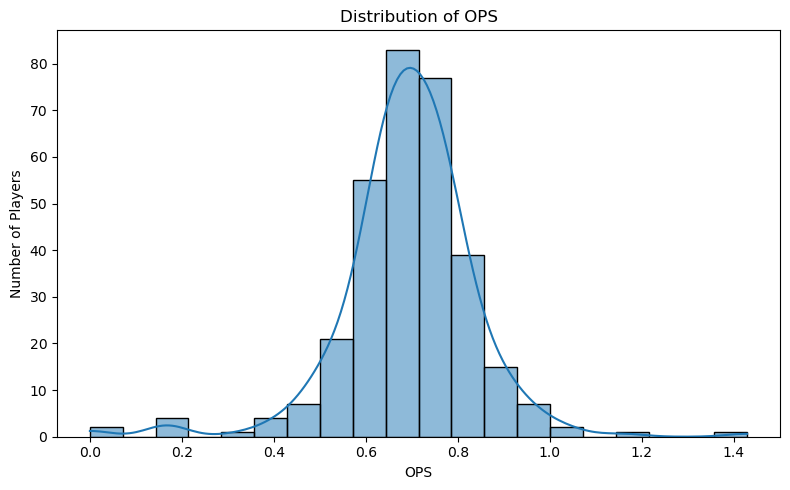

In [14]:
# Histogram
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(analysis_df['OPS'], kde=True, bins=20)
plt.title('Distribution of OPS')
plt.xlabel('OPS')
plt.ylabel('Number of Players')
plt.tight_layout()
plt.show()

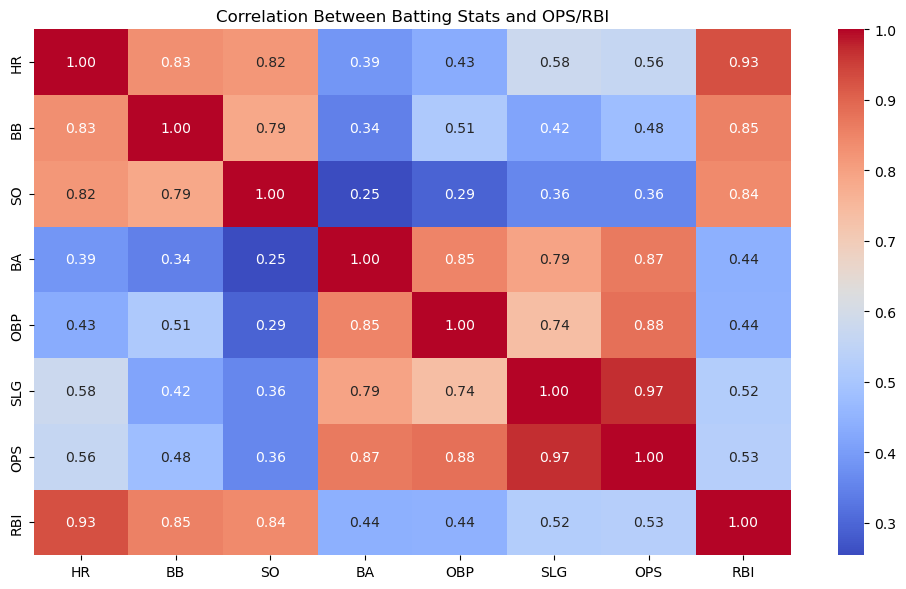

In [15]:
# Correlation Matrix
bivariate_vars = ['HR', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'RBI']
corr = analysis_df[bivariate_vars].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Batting Stats and OPS/RBI")
plt.tight_layout()
plt.show()

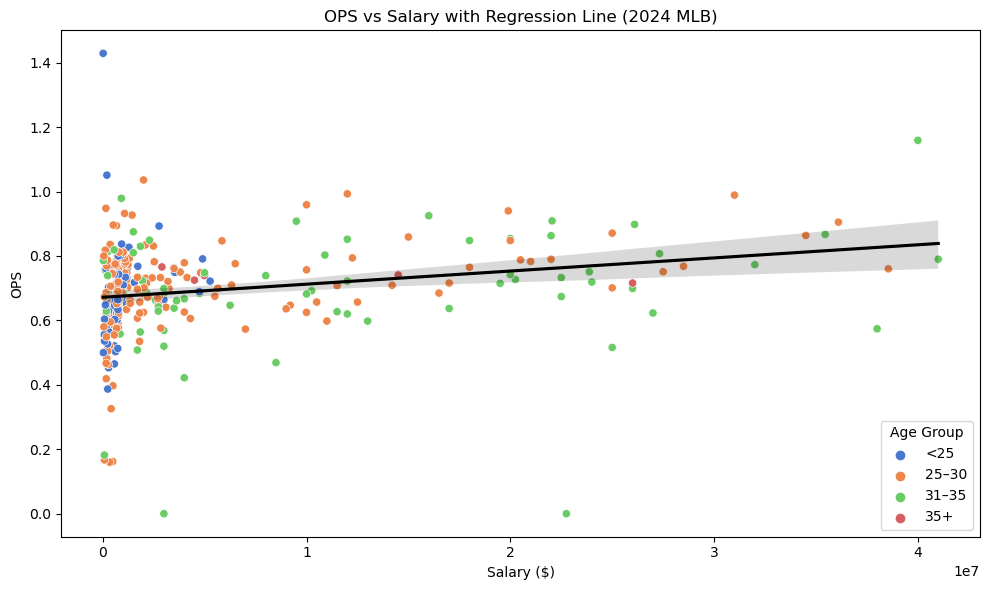

In [30]:
# Create age groups 
bins = [0, 24, 30, 35, 100]
labels = ['<25', '25–30', '31–35', '35+']
analysis_df['AgeGroup'] = pd.cut(analysis_df['Age'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x="Salary", y="OPS", hue="AgeGroup", palette="muted")
sns.regplot(data=analysis_df, x="Salary", y="OPS", scatter=False, color="black", line_kws={"linestyle": "solid"})

plt.title("OPS vs Salary with Regression Line (2024 MLB)")
plt.xlabel("Salary ($)")
plt.ylabel("OPS")
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()

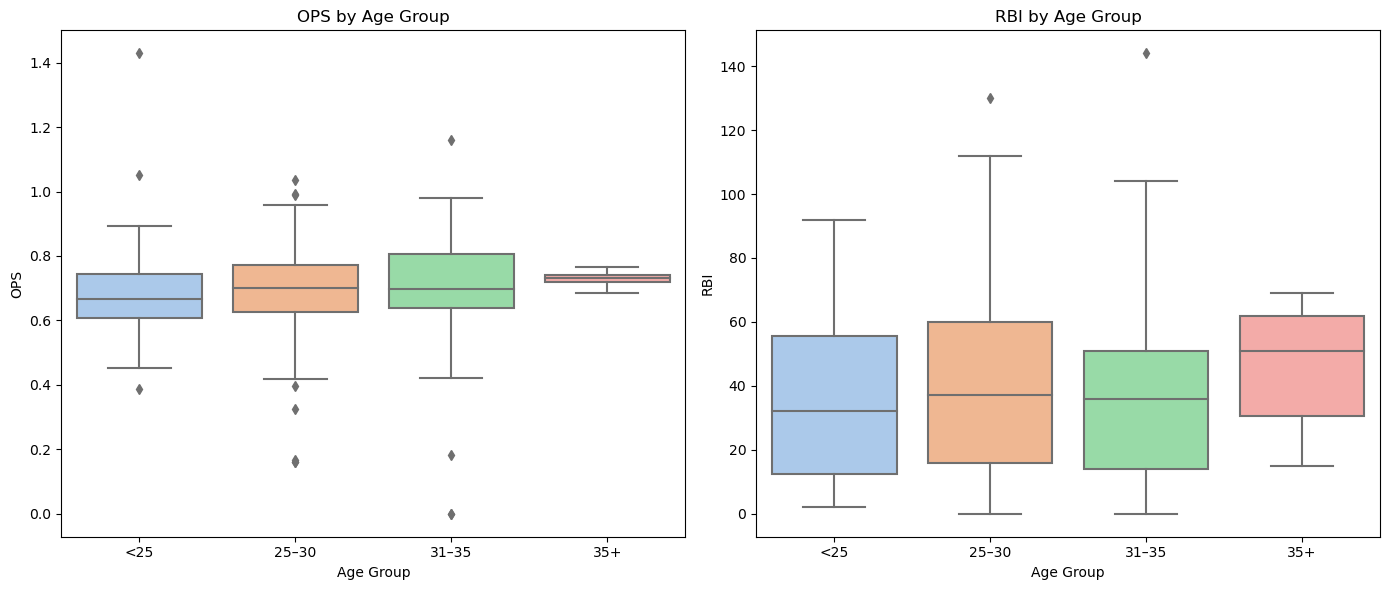

In [17]:
plt.figure(figsize=(14, 6))

# Boxplot for OPS
plt.subplot(1, 2, 1)
sns.boxplot(data=analysis_df, x='AgeGroup', y='OPS', palette='pastel')
plt.title('OPS by Age Group')
plt.ylabel('OPS')
plt.xlabel('Age Group')

# Boxplot for RBI
plt.subplot(1, 2, 2)
sns.boxplot(data=analysis_df, x='AgeGroup', y='RBI', palette='pastel')
plt.title('RBI by Age Group')
plt.ylabel('RBI')
plt.xlabel('Age Group')

plt.tight_layout()
plt.show()

In [18]:
# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = analysis_df[['HR', 'BB', 'SO', 'OBP', 'SLG']]
y = analysis_df['RBI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.8805624902946845


### Who are the most undervalued/overvalued players?

In [21]:
df = pd.read_csv("merged_mlb_2024.csv")

# Clean salary column
df["Salary"] = df["Salary"].replace('[\$,]', '', regex=True).astype(float)
# Drop rows with missing key stats
df = df[["Player", "Team", "OPS", "HR", "RBI", "Salary"]].dropna()

X = df[["OPS", "HR", "RBI"]]
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

r_squared = model.score(X_test, y_test)
print(f"Model R2: {r_squared:.4f}")

df["PredictedSalary"] = model.predict(X)

df["SalaryDifference"] = df["Salary"] - df["PredictedSalary"]

most_underpaid = df.sort_values(by="SalaryDifference").head(10)
most_overpaid = df.sort_values(by="SalaryDifference", ascending=False).head(10)
print("\nMost Underpaid Players:")
print(most_underpaid[["Player", "Team", "Salary", "PredictedSalary", "SalaryDifference"]])

print("\nMost Overpaid Players:")
print(most_overpaid[["Player", "Team", "Salary", "PredictedSalary", "SalaryDifference"]])


Model R2: 0.3627

Most Underpaid Players:
               Player Team     Salary  PredictedSalary  SalaryDifference
1       Shohei Ohtani  LAD  2000000.0     1.849398e+07     -1.649398e+07
43       Brent Rooker  OAK  1437804.0     1.436387e+07     -1.292606e+07
2    Gunnar Henderson  BAL  2763378.0     1.316107e+07     -1.039769e+07
56        Jake Burger  MIA   760000.0     1.079873e+07     -1.003873e+07
77    Shea Langeliers  OAK  1000500.0     1.097600e+07     -9.975503e+06
112      Mark Vientos  NYM   927690.0     1.004376e+07     -9.116070e+06
21      Spencer Steer  CIN   750000.0     9.317355e+06     -8.567355e+06
52      Alec Burleson  STL   750050.0     9.002586e+06     -8.252536e+06
49          Zach Neto  LAA  1192551.0     9.409880e+06     -8.217329e+06
55       Riley Greene  DET  1284146.0     9.457135e+06     -8.172989e+06

Most Overpaid Players:
                Player Team      Salary  PredictedSalary  SalaryDifference
214     Anthony Rendon  LAA  38000000.0     1.743356e+06